In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from matplotlib import pyplot as plt
from torchvision import transforms


device = (torch.device('cuda') if torch.cuda.is_available()
 else torch.device('cpu'))
print(f"Training on device {device}.")

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
data_path = './data'

tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=True,transform=transforms.ToTensor()) 

tensor_cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,transform=transforms.ToTensor())

cifar2 =  tensor_cifar10
cifar2_val = tensor_cifar10_val

class Net(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, 
                loss_train / len(train_loader)))


train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
 shuffle=True)
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2) #
loss_fn = nn.CrossEntropyLoss()
training_loop(
  n_epochs = 100,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)
torch.save(model.state_dict(), 'trtt.pt')


train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
 shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
 shuffle=False)
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))
validate(model, train_loader, val_loader)


Training on device cuda.


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
2023-03-11 12:12:34.689146 Epoch 1, Training loss 1.7984917397084443
2023-03-11 12:14:09.829712 Epoch 10, Training loss 0.9662529781956197
2023-03-11 12:15:53.458901 Epoch 20, Training loss 0.7859439551449188
2023-03-11 12:17:38.879591 Epoch 30, Training loss 0.695777148046457
2023-03-11 12:19:24.130956 Epoch 40, Training loss 0.6288938818837676
2023-03-11 12:21:10.006055 Epoch 50, Training loss 0.5732376047641116
2023-03-11 12:22:56.314022 Epoch 60, Training loss 0.5253338150851562
2023-03-11 12:24:40.278294 Epoch 70, Training loss 0.48232757439241386
2023-03-11 12:26:23.853528 Epoch 80, Training loss 0.44287997141213675
2023-03-11 12:28:07.582567 Epoch 90, Training loss 0.4096080708076887
2023-03-11 12:29:51.134647 Epoch 100, Training loss 0.37951068410559385
Accuracy train: 0.88
Accuracy val: 0.66


Files already downloaded and verified


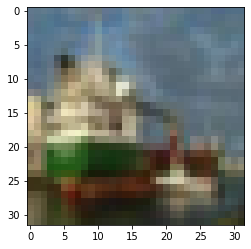

ship


In [17]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=False, download=True,transform=transforms.ToTensor()) 
img, label = tensor_cifar10[51]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(class_names[model(img.to(device=device).view(1,3,32,32))[0].tolist().index(max(model(img.to(device=device).view(1,3,32,32))[0].tolist()))])
